<a href="https://colab.research.google.com/github/ysneef/Data-Analytics-and-Deep-Learning/blob/main/Brand_Logo_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
sushovansaha9_flickr_logos_27_dataset_path = kagglehub.dataset_download('sushovansaha9/flickr-logos-27-dataset')

print('Data source import complete.')

100%|██████████| 97.3M/97.3M [00:00<00:00, 135MB/s]

Extracting files...


Data source import complete.


# Xception

In [2]:
# import the necessary packages
!pip install imutils
!pip install wget
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dropout,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import wget
import cv2
import tensorflow as tf
import tensorflow_datasets.public_api as tfds

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=146b15ffb87dcb369076f2534dc3f2c88d6689f83ff7a7fc384b2b13a282c0a9
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## Downloading Dataset

In [3]:
_URL = 'http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz'
wget.download(_URL)

'flickr_logos_27_dataset.tar.gz'

In [4]:
!ls

flickr_logos_27_dataset.tar.gz	sample_data


In [6]:
zip_dir = tf.keras.utils.get_file(fname="logo", origin=_URL, untar=True, extract=True, cache_dir="./")

101827904/101827904 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [7]:
import tarfile

fname = './flickr_logos_27_dataset.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [8]:
fname = './flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [11]:
fname = './flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [13]:
src_dir = "flickr_logos_27_dataset_images"
dest = "LOGOS"

if not os.path.exists(dest):
    os.makedirs(dest)

## Preprocessing

In [14]:
import pandas as pd

In [15]:
df = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt", sep='\s+',header=None)

In [16]:
df

,0,1,2,3,4,5,6
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


In [17]:
X = df.iloc[:,0]
Y = df.iloc[:,1]

In [18]:
dtdir = './flickr_logos_27_dataset_images/'

In [19]:
im = df[0][0]

In [20]:
size = df.iloc[:,3:]

In [21]:
size

,3,4,5,6
0,38,12,234,142
1,242,208,413,331
2,13,5,89,60
3,43,122,358,354
4,83,63,130,93
...,...,...,...,...
4531,15,6,253,54
4532,136,161,304,222
4533,2,4,499,106
4534,1,69,342,157


In [22]:
img = os.path.join(dtdir,im)

In [23]:
size = size.values.tolist()

In [24]:
size[0][0],size[0][1],size[0][2],size[0][3]

(38, 12, 234, 142)

(210, 280, 3)

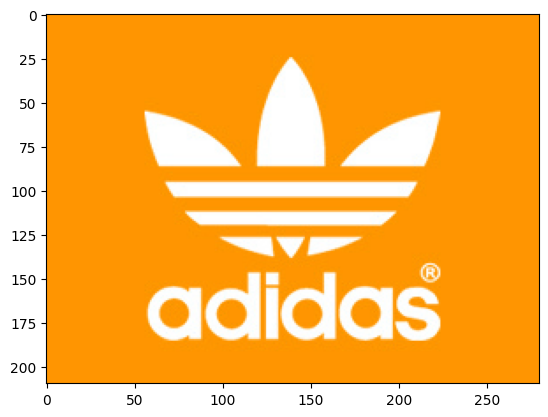

In [25]:
image = cv2.imread(img)
plt.imshow(image)
image.shape

(130, 196, 3)

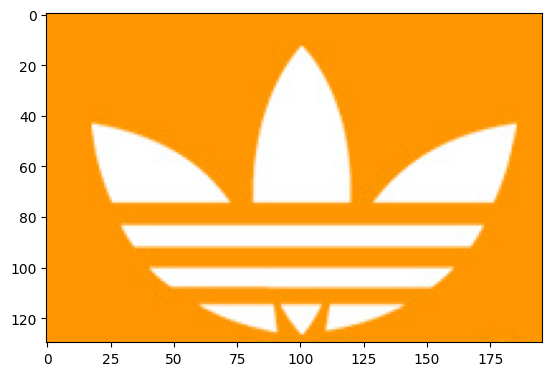

In [26]:
image = cv2.imread(img)
image = image[size[0][1]:size[0][3],size[0][0]:size[0][2]]
plt.imshow(image)
image.shape

In [27]:
query = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep='\s+',header=None)

In [28]:
query

,0,1
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


(500, 437, 3)

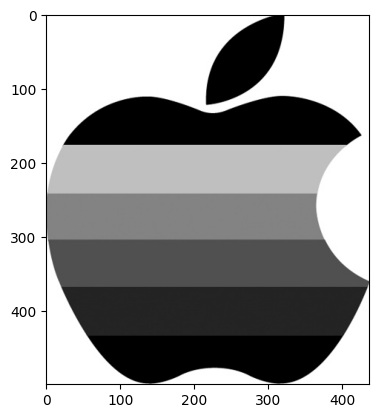

In [29]:
img = os.path.join(dtdir,query[0][5])
image = cv2.imread(img)
plt.imshow(image)
image.shape

In [30]:
testdist = 'TEST'

In [31]:
if not os.path.exists(testdist):
    os.makedirs(testdist)

In [32]:

y = list(set(list(Y)))
y.sort()

In [33]:
for i in y:
    os.makedirs(os.path.join(testdist,i))

In [34]:
for i in y:
    os.makedirs(os.path.join(dest,i))

In [35]:
distractor = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt", sep='\s+',header=None)

In [36]:
distractor

,0
0,http://farm2.static.flickr.com/1184/1013364004...
1,http://farm2.static.flickr.com/1108/1047095104...
2,http://farm2.static.flickr.com/1359/1076885577...
3,http://farm1.static.flickr.com/53/110432189_6d...
4,http://farm2.static.flickr.com/1144/1153048029...
...,...
4202,http://farm2.static.flickr.com/1254/889763557_...
4203,http://farm2.static.flickr.com/1308/901063602_...
4204,http://farm1.static.flickr.com/18/93551127_fed...
4205,http://farm2.static.flickr.com/1033/978252884_...


In [37]:
HEIGHT = 224
WIDTH =  224

## Removing Corrupt Images

In [38]:
for i in range(len(X)):
    try:
        destrain = os.path.join(dest,Y[i])
        savepath = os.path.join(destrain,X[i])
        img  = os.path.join(dtdir,X[i])
        image = cv2.imread(img)
        image = image[size[i][1]:size[i][3],size[i][0]:size[i][2]]
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass

error
error
error
error
error


In [39]:
A = query.iloc[:,0]
B = query.iloc[:,1]

In [40]:
A

,0
0,2403695909.jpg
1,2912587920.jpg
2,3441398196.jpg
3,4605630935.jpg
4,4606245138.jpg
...,...
265,3480640208.jpg
266,3486224308.jpg
267,3486430785.jpg
268,3490185235.jpg


In [41]:

for i in range(len(A)):
    try:
        destrain = os.path.join(testdist,B[i])
        savepath = os.path.join(destrain,A[i])
        img  = os.path.join(dtdir,A[i])
        image = cv2.imread(img)
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


In [42]:
imagePaths = list(paths.list_images(testdist))

TEST/Cocacola/2145962231.jpg


(224, 224, 3)

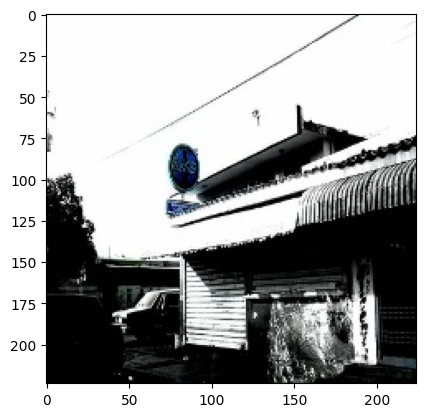

In [43]:
img = imagePaths[40]
print(img)
image = cv2.imread(img)
plt.imshow(image)
image.shape

## Image Augmentation

In [44]:
train = ImageDataGenerator(
rescale = 1/255,
horizontal_flip=True,
vertical_flip=True,
shear_range=0.2,
zoom_range=0.2,
featurewise_center=True, # Set input mean to 0 over the dataset, feature-wise
featurewise_std_normalization=True, # Divide inputs by std of the dataset, feature-wise
rotation_range=40, # Degree range for random rotations
width_shift_range=0.2,
height_shift_range=0.2,
fill_mode='nearest',
validation_split = 0.2)

In [45]:
imagePaths = list(paths.list_images(dest))

In [46]:
os.makedirs('preview')

In [47]:
img = load_img(imagePaths[50])  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='yh', save_format='jpeg'):
    i += 1
    if i > 10:
        break  # otherwise the generator would loop indefinitely

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


## Samples Visualization

(224, 224, 3)

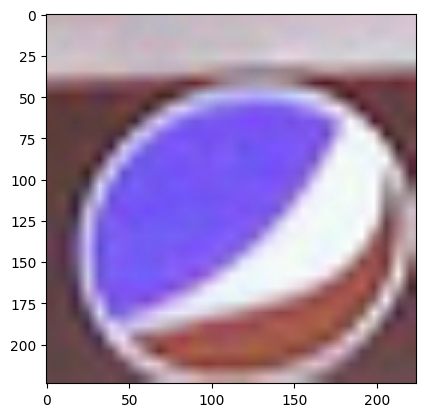

In [48]:
image = cv2.imread(imagePaths[50])
plt.imshow(image)
image.shape

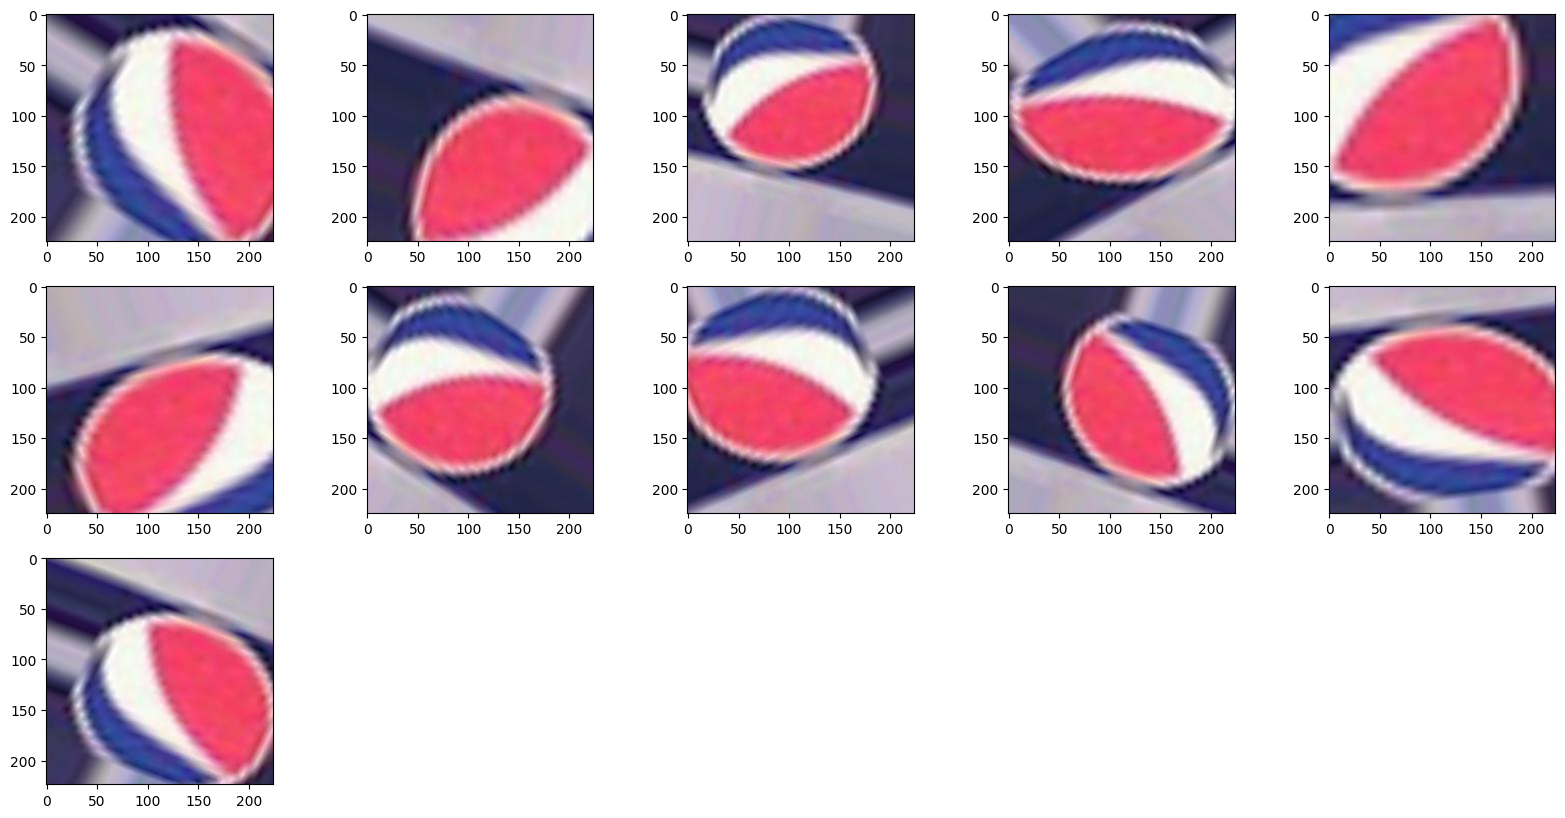

In [49]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('preview/*.jpeg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [50]:
HEIGHT = 224
WIDTH = 224
INIT_LR = 1e-4
EPOCHS =  100
BS = 256

## Splitting into Train and Validation Set

In [51]:
trainset = train.flow_from_directory(dest,
target_size = (WIDTH,HEIGHT),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
subset = 'training',
class_mode='categorical')

Found 648 images belonging to 27 classes.


In [52]:
validset = train.flow_from_directory(dest,
target_size = (WIDTH,HEIGHT),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
subset = 'validation',
class_mode='categorical')

Found 161 images belonging to 27 classes.


In [53]:
imagePaths = list(paths.list_images(dest))

In [54]:
#trainset.filenames

In [55]:
trainset.class_indices

{'Adidas': 0,
 'Apple': 1,
 'BMW': 2,
 'Citroen': 3,
 'Cocacola': 4,
 'DHL': 5,
 'Fedex': 6,
 'Ferrari': 7,
 'Ford': 8,
 'Google': 9,
 'HP': 10,
 'Heineken': 11,
 'Intel': 12,
 'McDonalds': 13,
 'Mini': 14,
 'Nbc': 15,
 'Nike': 16,
 'Pepsi': 17,
 'Porsche': 18,
 'Puma': 19,
 'RedBull': 20,
 'Sprite': 21,
 'Starbucks': 22,
 'Texaco': 23,
 'Unicef': 24,
 'Vodafone': 25,
 'Yahoo': 26}

## Model Architecture

In [56]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(WIDTH, HEIGHT, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output

headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(trainset.num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
#sgd = SGD(lr=INIT_LR,momentum=0.9,nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer='Adam',metrics=["accuracy"])
# train the head of the network

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
[INFO] compiling model...


In [57]:
totalTrain = len(list(paths.list_images(dest)))
totalTrain

809

## Train Results

In [ ]:
H = model.fit(
    trainset,
    validation_data=validset,
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 208s 68s/step - accuracy: 0.0326 - loss: 3.5945 - val_accuracy: 0.1242 - val_loss: 3.1186
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 191s 64s/step - accuracy: 0.1338 - loss: 3.0390 - val_accuracy: 0.2609 - val_loss: 2.9782
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 200s 82s/step - accuracy: 0.2040 - loss: 2.9575 - val_accuracy: 0.3106 - val_loss: 2.8648
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 194s 78s/step - accuracy: 0.3085 - loss: 2.6794 - val_accuracy: 0.3168 - val_loss: 2.6321
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 193s 66s/step - accuracy: 0.2383 - loss: 2.7486 - val_accuracy: 0.3789 - val_loss: 2.4496
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 204s 84s/step - accuracy: 0.3615 - loss: 2.4227 - val_accuracy: 0.4410 - val_loss: 2.2570
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 193s 79s/step - accuracy: 0.4044 - loss: 2.2899 - val_accuracy: 0.4658 - val_loss: 2.0841
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 194s 65s/step - accuracy: 0.3612 - loss: 2.3043 - val_accuracy: 0.5590 - val_loss: 1.9